<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 7</strong>
</div>
<div style="text-align: center;">
<strong>RB-Galerkin for Poisson equation</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

# 1 Imports and helper functions

In [1]:
from math import pi
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import time

def chebpts(n, dom=[-1, 1]):
    """Return n Chebyshev points of the second kind."""
    
    if n == 1:
        x = np.array([-1])
    else:
        x = -np.cos(np.array([j for j in range(n)])*np.pi/(n-1))
    x = dom[1]*(x + 1)/2 + dom[0]*(1 - x)/2
    
    return x

def quadwts(n, dom=[-1, 1]):
    """Return n weights for Clenshaw-Curtis quadrature."""
    
    c = 2/np.concatenate(([1],  1 - np.arange(2, n, 2)**2), axis=0)
    c = np.concatenate((c, c[int(n/2)-1:0:-1]), axis=0)
    w = np.real(np.fft.ifft(c))
    w[0] = w[0]/2
    w = np.concatenate((w, [w[0]]), axis=0)
    w = (dom[1] - dom[0])/2*w
    
    return w

# 2 RB-Galerkin for Poisson equation

We consider the one-dimensional Poisson equation with homogeneous Dirichlet boundary conditions:

\begin{align}
& -u''(x;\mu) = f(x;\mu), \quad x \in[0,1], \\
& \phantom{-}u(0;\mu) = u(1;\mu) = 0.
\end{align}

We will take the following righ-hand side $f$ and exact solution,
$$
f(x;\mu) = e^{-5(x - \mu)^2}, \qquad u(x;\mu) = \int_0^1g(x,y)f(y;\mu)dy, \qquad g(x,y) = \frac{1}{2}(x + y - \vert y-x\vert)-xy.
$$

The exact solution is computed from the Green's function $g$ with a Clenshaw-Curtis quadrature to approximate the integral; see, e.g., <a href="https://en.wikipedia.org/wiki/Green%27s_function" style="color: blue">this</a> and <a href="https://en.wikipedia.org/wiki/Clenshaw%E2%80%93Curtis_quadrature" style="color: blue">this</a>.

**Note: In this problem, the parameter $\mu$ comes from the right-hand side $f(\cdot;\mu)$.**

We discretize space with

$$
x_j = jh, \quad h=1/(N_h+1), \quad 0\leq j\leq N_h+1.
$$

We have the following $N_h$ basis functions on $[0, 1]$. Note the differences in $x_j$ and $h$ compared to $[-1,1]$. The $N_h$ degrees of freedom are the values at the $N_h$ interior grid points.

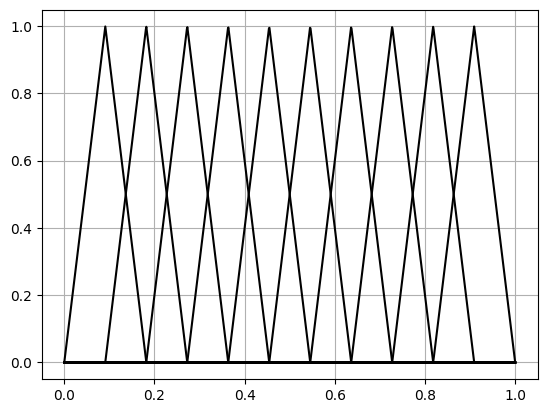

In [2]:
# Computation grid and basis functions:
N_h = 10
h = 1/(N_h + 1)
x_h = np.linspace(0, 1, N_h + 2)
phi = lambda x: (1 - np.abs(x)) * (np.abs(x) <= 1)
Phi = lambda i, x: phi((x - x_h[i])/h)

# Plot basis functions on a finer grid:
N_eval = 1000
x_eval = np.linspace(0, 1, N_eval + 1)
plt.figure()
for j in range(1, N_h + 1):
    plt.plot(x_eval, Phi(j, x_eval), 'k')
plt.grid();

## 2.1 Galerkin linear system

We seek a finite element approximation of $u$

$$
u_h(x;\mu) = \sum_{j=1}^{N_h} u_h^j(\mu)\phi_j(x), \qquad u_h^j(\mu) = u_h(x_j;\mu),
$$

which verifies the Galerkin variational problem

$$
\int_0^1 u_h'(x;\mu)\phi_i'(x)  dx  = \int_0^1 f(x;\mu)\phi_i(x)dx, \qquad 1\leq i\leq N_h.
$$

By substituting the expression for $u_h$, we obtain the following linear system,

$$
\sum_{j=1}^{N_h} u_h^j(\mu)\int_0^1 \phi_i'(x)\phi_j'(x)dx = \int_0^1 f(x;\mu)\phi_i(x)dx, \qquad 1\leq i\leq N_h.
$$ 

We set

$$
(A_h)_{ij} = \int_0^1 \phi_i'(x)\phi_j'(x)dx, \qquad (F_h(\mu))_i = \int_0^1 f(x;\mu)\phi_i(x)dx, \qquad (M_h)_{ij} = \int_0^1 \phi_i(x)\phi_j(x)dx.
$$

Then the $N_h\times N_h$ Galerkin linear system reads

$$
A_hU_h(\mu) = F_h(\mu) \approx M_h\widetilde{F}_h(\mu),
$$

with unknown $U_h(\mu) = (u_h^1(\mu),\ldots,u_h^{N_h}(\mu))^T$ and

$$
A_h = \frac{1}{h}\mathrm{tridiag}(-1, 2, -1), \quad M_h = \frac{h}{3}\mathrm{tridiag}(0.5, 2, 0.5), \quad \widetilde{F}_h(\mu) = \begin{pmatrix} f(x_1;\mu) \\ \vdots \\ f(x_{N_h};\mu) \end{pmatrix}.
$$

In other words,

$$
A_h = \frac{1}{h}\begin{pmatrix}
\phantom{-}2 & -1 \\
-1 & \phantom{-}2 & -1 \\
& \ddots & \ddots & \ddots \\
& & -1 & \phantom{-}2 & -1 \\
& & & -1 & \phantom{-}2
\end{pmatrix}, \qquad
M_h = \frac{h}{3}\begin{pmatrix}
2 & 0.5 \\
0.5 & 2 & 0.5 \\
& \ddots & \ddots & \ddots \\
& & 0.5 & 2 & 0.5 \\
& & & 0.5 & 2
\end{pmatrix}.
$$

We aslo recall that we can assemble the matrices and solve the Galerkin linear system like this.

In [3]:
def assemble_matrices(N_h):
    """
    Assemble the stiffness matrix A_h and mass matrix M_h for the Galerkin method.

    Parameters
    ----------
    N_h : int
        The number of interior grid points.

    Returns
    -------
    A_h : scipy.sparse.csc_matrix
        The stiffness matrix of size (N_h, N_h).
    M_h : scipy.sparse.csc_matrix
        The mass matrix of size (N_h, N_h).
    """

    # Grid size:
    h = 1/(N_h + 1)

    # Stiffness matrix:
    d1 = [-1] * (N_h - 1)
    d0 = [2] * N_h
    A_h = 1/h * diags([d1, d0, d1], [-1, 0, 1], format='csc')

    # Mass matrix:
    d1 = [0.5] * (N_h - 1)
    M_h = h/3 *  diags([d1, d0, d1], [-1, 0, 1], format='csc')
    
    return A_h, M_h

def solve_galerkin(N_h, mu):
    """
    Solve the Galkerin linear system.

    Parameters
    ----------
    N_h : int
        The number of interior grid points.
    mu : float
        The parameter for the right-hand side f.

    Returns
    -------
    np.ndarray
        The solution vector of size (N_h,).
    """

    # Grid:
    x_h = np.linspace(0, 1, N_h + 2)
    
    # Construct the matrices:
    A_h, M_h = assemble_matrices(N_h)

    # Solve the linear system:
    U_h = spsolve(A_h, M_h @ f(x_h[1:-1], mu))
    
    return U_h

### Validation

Time (online): 0.01835s
Error (L-inf): 2.49e-04


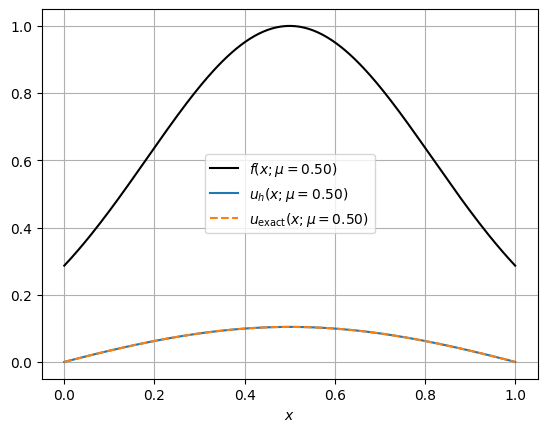

In [4]:
# ODE setup:
mu = 0.5
f = lambda x, mu: np.exp(-5*(x - mu)**2)
g = lambda x, y: 0.5 * (x[:, None] + y - np.abs(x[:, None] - y)) - x[:, None] * y
y = chebpts(200, [0, 1])
w = quadwts(200, [0, 1])
u_ex = lambda x, mu: w @ (g(x, y).T * f(y, mu)[:, None])
    
# Grid setup:
N_h = 100
h = 1/(N_h + 1)
x_h = np.linspace(0, 1, N_h + 2) # computation grid
N_eval = 200
x_eval = np.linspace(0, 1, N_eval) # evaluation grid

# Solve Galerkin linear system:
start = time.time() 
U_h = solve_galerkin(N_h, mu)
end = time.time()    
print(f'Time (online): {end-start:.5f}s')

# Evalute the approximate solution on the evaluation grid:
I, XEVAL = np.meshgrid(np.arange(1, N_h + 1), x_eval)
u_h = Phi(I, XEVAL) @ U_h

# Compute the L-inf error:
error = np.max(np.abs(u_ex(x_eval, mu) - u_h))/np.max(np.abs(u_ex(x_eval, mu)))
print(f'Error (L-inf): {error:.2e}')

# Plot:
plt.figure()
plt.plot(x_eval, f(x_eval, mu), '-k', label=r'$f(x; \mu = %.2f)$' % mu)
plt.plot(x_eval, u_h, '-', label=r'$u_h(x; \mu = %.2f)$' % mu)
plt.plot(x_eval, u_ex(x_eval, mu), '--', label=r'$u_\mathrm{exact}(x; \mu = %.2f)$' % mu)
plt.xlabel(r"$x$")
plt.grid()
plt.legend();

## 2.2 Snapshots

Next, we assemble the snapshot matrix

$$
S = [U_h(\mu_1) | \ldots | U_h(\mu_n)] \in \R^{N_h\times n}.
$$

### Exercise

{exercise}
Complete the missing parts. 

The $L^\infty$-error should be around $10^{-4}$.

In [5]:
def compute_snapshots(N_h, n, mu):
    """
    Compute a set of solution snapshots using the Galerkin method.

    Parameters
    ----------
    N_h : int
        The number of interior grid points.
    n : int
        The number of parameter samples.
    mu : np.ndarray
        The vector of parameter values.

    Returns
    -------
    S : np.ndarray
        A matrix of shape (N_h, n) where each column is a solution snapshot.
    """
    
    # Initialize the matrix:
    S = np.zeros((N_h, n))

    # Loop over the parameter values:
    for i in range(n):
        S[:, i] = solve_galerkin(N_h, mu[i])
        
    return S

### Validation

In [6]:
# Compute snapshots:
n = 50
mu_val = np.linspace(0.25, 0.75, n)
start = time.time() 
S = compute_snapshots(N_h, n, mu_val)
end = time.time()
print(f'Time (offline): {end-start:.5f}s')

# Compute exact snapshots:
S_ex = np.zeros((N_h, n))
for i in range(n):
    S_ex[:, i] = u_ex(x_h[1:-1], mu_val[i])

# Compute the L-inf error:
error = np.max(np.abs(S - S_ex))/np.max(np.abs(S_ex))
print(f'Error  (L-inf): {error:.2e}')

Time (offline): 0.07371s
Error  (L-inf): 1.55e-04


## 2.3 Reduced basis

Now, we compute the SVD of $S=U\Sigma V^T$ and set

$$
W = [U_1 | \ldots U_N] \in \R^{N_h\times N},
$$

where $N$ is chosen such that

$$
\frac{\sum_{j=1}^N\sigma_j^2}{\sum_{j=1}^r\sigma_j^2} \geq 1 - \epsilon^2.
$$

### Exercise

{exercise}
Complete the missing parts. 

The singular values should decay to  $10^{-16}$ and $N$ should be equal to $5$, corresponding to a singular value around $10^{-6}$.

In [7]:
def compute_reduced_basis(S, epsilon):
    """
    Computes a reduced basis using Singular Value Decomposition (SVD) by selecting the
    first N singular vectors that capture a desired amount of energy.

    Parameters
    ----------
    S : numpy.ndarray
        The input matrix for which the reduced basis is to be computed. It should be of shape (N_h, n). 
    epsilon : float
        The energy threshold (0 < epsilon < 1). It determines the fraction of the total energy 
        to be captured by the reduced basis.

    Returns
    -------
    W : numpy.ndarray
        The matrix of the first N singular vectors (reduced basis), with shape (N_h, N), where N is the 
        number of singular vectors selected.
    Sigma : numpy.ndarray
        The vector of singular values of S.
    N : int
        The number of singular vectors selected, corresponding to the desired energy threshold.
    
    Notes
    -----
    The function performs an SVD on the input matrix `S`, computes the cumulative energy captured 
    by the singular values, and selects the minimum number of singular vectors that capture at least 
    (1 - epsilon^2) of the total energy.
    """

    # SVD:
    U, Sigma, VT = np.linalg.svd(S, full_matrices=False)

    # Choose N from epsilon:
    N = 1
    while (np.sum(Sigma[:N]**2) / np.sum(Sigma**2)) < (1 - epsilon**2):
        N += 1

    # Select the first N singular vectors:
    W = U[:, :N]

    return W, Sigma, N    

### Validation

5 2.7349956002984336e-06 2.8187489420904767e-16


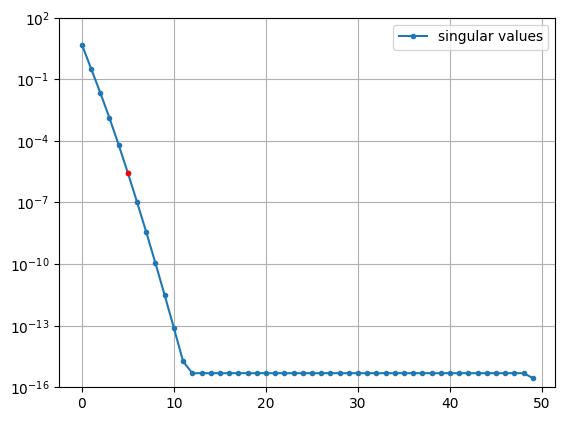

In [8]:
epsilon = 1e-6
W, Sigma, N = compute_reduced_basis(S, epsilon)
print(N, Sigma[N], Sigma[-1])

plt.figure()
plt.semilogy(Sigma, '.-', label="singular values")
plt.semilogy(N, Sigma[N], '.r')
plt.ylim(1e-16, 1e2)
plt.grid()
plt.legend();

## 2.4 Reduced Galerkin linear system

We finally compute a solution for a new $\mu$ via

$$
A_NU_N(\mu) = F_N(\mu),
$$

where

$$
A_N = W^TA_hW, \qquad F_N(\mu) = W^TF_h(\mu) \approx W^TM_h\widetilde{F}_h(\mu).
$$

### Exercise

{exercise}
Complete the missing parts. 

The $L^\infty$-error should be around $10^{-4}$.

In [9]:
def solve_reduced_galerkin(W, N_h, mu):
    """
    Solves the reduced Galerkin linear system using the reduced basis.

    Parameters
    ----------
    W : numpy.ndarray
        The matrix of the reduced basis, with shape (N_h, N).
    N_h : int
        The number of interior grid points.
    mu : float
        The parameter for the right-hand side f.

    Returns
    -------
    U_N : numpy.ndarray
        The solution of the reduced Galerkin system in the reduced space, with shape (N,).
    
    Notes
    -----
    The function computes the reduced Galerkin system by projecting the original system onto the 
    reduced basis. The matrix `A_N` is the reduced stiffness matrix, and `F_N` is the reduced source term. 
    The system is solved for `U_N`, which is the solution in the reduced space.
    """

    # Construct the matrices:
    A_h, M_h = assemble_matrices(N_h)

    # Construct the reduced system:
    A_N = W.T @ A_h @ W
    F_N = W.T @ M_h @ f(x_h[1:-1], mu)

    # Solve the reduced system:
    start = time.time() 
    U_N = spsolve(A_N, F_N)
    end = time.time()
    print(f'Time (online): {end-start:.5f}s')
    
    return U_N

### Validation

C:\Users\ethan\AppData\Local\Temp\ipykernel_25568\643468402.py:35: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  U_N = spsolve(A_N, F_N)


Time (online): 0.00557s
Error (L-inf): 2.74e-04


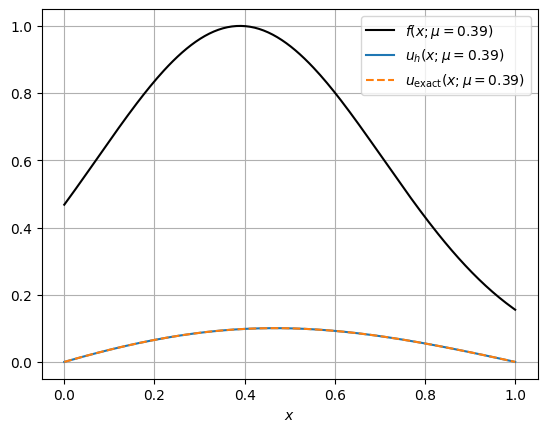

In [10]:
# Compute solution for new mu:
mu_new = mu_val[0] + (mu_val[-1] - mu_val[0]) * np.random.rand()
U_N = solve_reduced_galerkin(W, N_h, mu_new)

# Evaluate solution:
I, XEVAL = np.meshgrid(np.arange(1, N_h + 1), x_eval)
u_h = Phi(I, XEVAL) @ W @ U_N

# Compute the L-inf error:
error = np.max(np.abs(u_ex(x_eval, mu_new) - u_h))/np.max(np.abs(u_ex(x_eval, mu_new)))
print(f'Error (L-inf): {error:.2e}')

# Plot:
plt.figure()
plt.plot(x_eval, f(x_eval, mu_new), '-k', label=r'$f(x; \mu = %.2f)$' % mu_new)
plt.plot(x_eval, u_h, '-', label=r'$u_h(x; \mu = %.2f)$' % mu_new)
plt.plot(x_eval, u_ex(x_eval, mu_new), '--', label=r'$u_\mathrm{exact}(x; \mu = %.2f)$' % mu_new)
plt.xlabel(r"$x$")
plt.grid()
plt.legend();